# Softmax - MNIST

En este notebook vamos a ver la implementación de Softmax en NumPy para clasificación multiclase. Vamos a aplicar el modelo al dataset de dígitos escritos a mano de la clase 2. 

## Cargamos las Librerías

In [41]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools
import random

RANDOM_STATE = 17

In [42]:
# Importar trabajos previos
import sys
#sys.path.insert(0, '/content/drive/MiUnidad../../clase_3/ejercicios/src')
from models import BaseModel
from metrics import Accuracy, Precision, Recall

## Cargamos el Dataset

In [43]:
# Cargamos los datos
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [44]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


In [45]:
clases = np.unique(y)
print(clases)

[0 1 2 3 4 5 6 7 8 9]


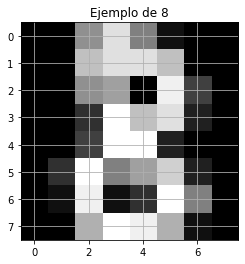

In [46]:
# Cargamos una muestra

plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')
plt.show()

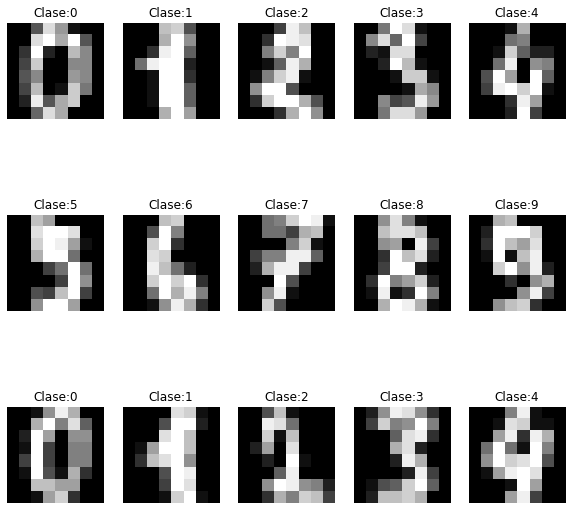

In [47]:
# Graficamos varias muestras

fig = plt.figure(figsize=(10, 10))
for i in range(15):  
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow(X[i].reshape(8, 8), cmap=plt.get_cmap('gray'))
    ax.set_title('Clase:{y}'.format(y=y[i]))
    plt.axis('off')
plt.show()

In [48]:
# Split del dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [49]:
X_train.shape

(1437, 64)

In [50]:
y_train.shape

(1437,)

## Creamos el Modelo

In [51]:
class Softmax(BaseModel):

    def fit(self, X, y, epochs, lr, batchSize, alpha, verbose=True, log=50):
        
        """
        shapes:
            X ==> n*m
            y ==> n*c
            W ==> m*c
        """
        
        # inicializamos aleatoriamente los pesos

        n = X.shape[0] # numero de muestras
        m = X.shape[1] # numero de features
        c = np.unique(y).shape[0] # numero de clases

        self.model = 0.001 * np.random.rand(m, c)
        
        # Inicializamos el término de velocidad (comprende el momento + gradiente de epoch)
        #self.velocity = np.zeros_like(self.model)
        
        y_hot = self.OneHotEncoding(y)
        
        train_loss = []

        for i in range(epochs):
            loss = self.MiniBatchGD(X, y_hot, lr, batchSize, alpha)
            train_loss.append(loss)
        
            if verbose:
                if i%log==0:
                    print("Epoch: {}, Loss: {}".format(i, loss))

        return train_loss

    def MiniBatchGD(self, X, y, lr, batchSize, alpha):
        
        losses = []
        
        # Hcemos un shuffle de los datos
        idx = random.sample(range(X.shape[0]), X.shape[0])
        X = X[idx]
        y = y[idx]
        
        for i in range(0, X.shape[0], batchSize):
            batch_X = X[i:i+batchSize]
            batch_y = y[i:i+batchSize]
            
            loss, dw = self.computeLoss(batch_X, batch_y, alpha)
            
            #self.velocity = (momentum * self.velocity) + (lr * dw)
            
            self.model = self.model - lr * dw
            
            losses.append(loss)
        
        return np.mean(losses)
    
    def softmaxEquation(self, z):
        
        # Restamos el máximos por estabilidad numérica
        z -= np.max(z)
        
        prob = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
        
        return prob
    

    def computeLoss(self, X, y, alpha):
        
        n = X.shape[0]
        
        # Calculamos el linear mapping y las predicciones con softmax
        z = np.dot(X, self.model)
        predictions = self.softmaxEquation(z)

        # Calculamos el loss total (modelo + regularización)
        # Modelo
        loss = -np.log(np.max(predictions)) * y
        # Regularización
        reg_loss = (1/2) * alpha * np.sum(self.model * self.model)
        # total
        total_loss = (np.sum(loss) / n) + reg_loss
        
        # Calculamos el gradiente
        gradient = ((-1 / n) * np.dot(X.T, (y - predictions))) + (alpha * self.model)
        
        return total_loss, gradient

    
    def OneHotEncoding(self, y):
        
        """
        shapes:
            y     --> nx1 
            y_hot --> nxc
            c = cantidad de clases    
        """    
        c = np.unique(y).shape[0]

        # matriz de ceros de nxc
        y_hot = np.zeros((len(y), c))

        # indexamos con el valor de y (0,1,...,9) y colocamos un 1
        y_hot[np.arange(len(y)), y] = 1

        return y_hot
    

    def predict(self, X):
        return np.argmax(X.dot(self.model), axis=1)


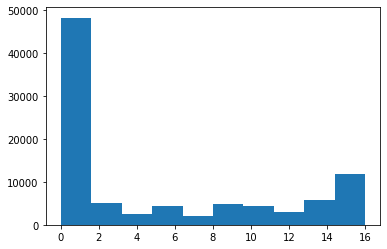

In [52]:
f, ax = plt.subplots()

ax.hist(X_train.flatten())

plt.show()

In [53]:
np.max(X_train)

16.0

In [54]:
# Escalamos las features

X_train_s = X_train / 16
X_test_s = X_test / 16

In [55]:
# Seleccionar hiperparámetros

lr = 0.01 # Learning rate
batchSize = 10 # Tamaño de los minibatch
epochs = 1000 # Epochs de entrenamiento
alpha = 0.001 # Peso de la regularización

In [56]:
softmax_clf = Softmax()

train_loss = softmax_clf.fit(X_train_s, y_train, epochs=epochs, lr=lr, batchSize=batchSize, alpha=alpha)

Epoch: 0, Loss: 2.075542860991602
Epoch: 50, Loss: 0.09807822965671258
Epoch: 100, Loss: 0.08963309183415544
Epoch: 150, Loss: 0.09570771261447458
Epoch: 200, Loss: 0.10076918557557958
Epoch: 250, Loss: 0.10587017422818033
Epoch: 300, Loss: 0.10982588869913396
Epoch: 350, Loss: 0.11345691634561063
Epoch: 400, Loss: 0.11561206142679782
Epoch: 450, Loss: 0.11794044354843579
Epoch: 500, Loss: 0.11979224566611994
Epoch: 550, Loss: 0.12115837847731552
Epoch: 600, Loss: 0.12229344046538412
Epoch: 650, Loss: 0.122634414561686
Epoch: 700, Loss: 0.12407546772036558
Epoch: 750, Loss: 0.12519629737443388
Epoch: 800, Loss: 0.1254026090894546
Epoch: 850, Loss: 0.12543972047237834
Epoch: 900, Loss: 0.1270123860481129
Epoch: 950, Loss: 0.1269518964688431


### Predicciones y Matriz de Confusión

In [57]:
def getConfusionMatrix(truth, prediction, c):

    conf_mtx =[]
    
    for _ in range(c):
        conf_mtx.append([])
        for _ in range(c):
            conf_mtx[-1].append(0)

    for i in range(truth.shape[0]):
        conf_mtx[int(truth[i])][int(prediction[i])] += 1
    
    conf_mtx = np.array(conf_mtx)
    
    conf_mtx = conf_mtx.astype('float') / conf_mtx.sum(axis=1)[:, np.newaxis]
    
    return conf_mtx

In [58]:
def plotConfusionMatrix(conf_mtx, c):
    plt.figure(figsize=(15,15))
    plt.imshow(conf_mtx, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(c)
    plt.xticks(tick_marks, np.arange(c) , rotation=45)
    plt.yticks(tick_marks, np.arange(c))

    fmt = '.2f'
    thresh = conf_mtx.max() / 2.

    for i, j in itertools.product(range(conf_mtx.shape[0]), range(conf_mtx.shape[1])):
        plt.text(j, i, format(conf_mtx[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mtx[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [59]:
predictions = softmax_clf.predict(X_test_s)

In [60]:
Acc = Accuracy()

In [61]:
Acc(y_test, predictions)

0.9583333333333334

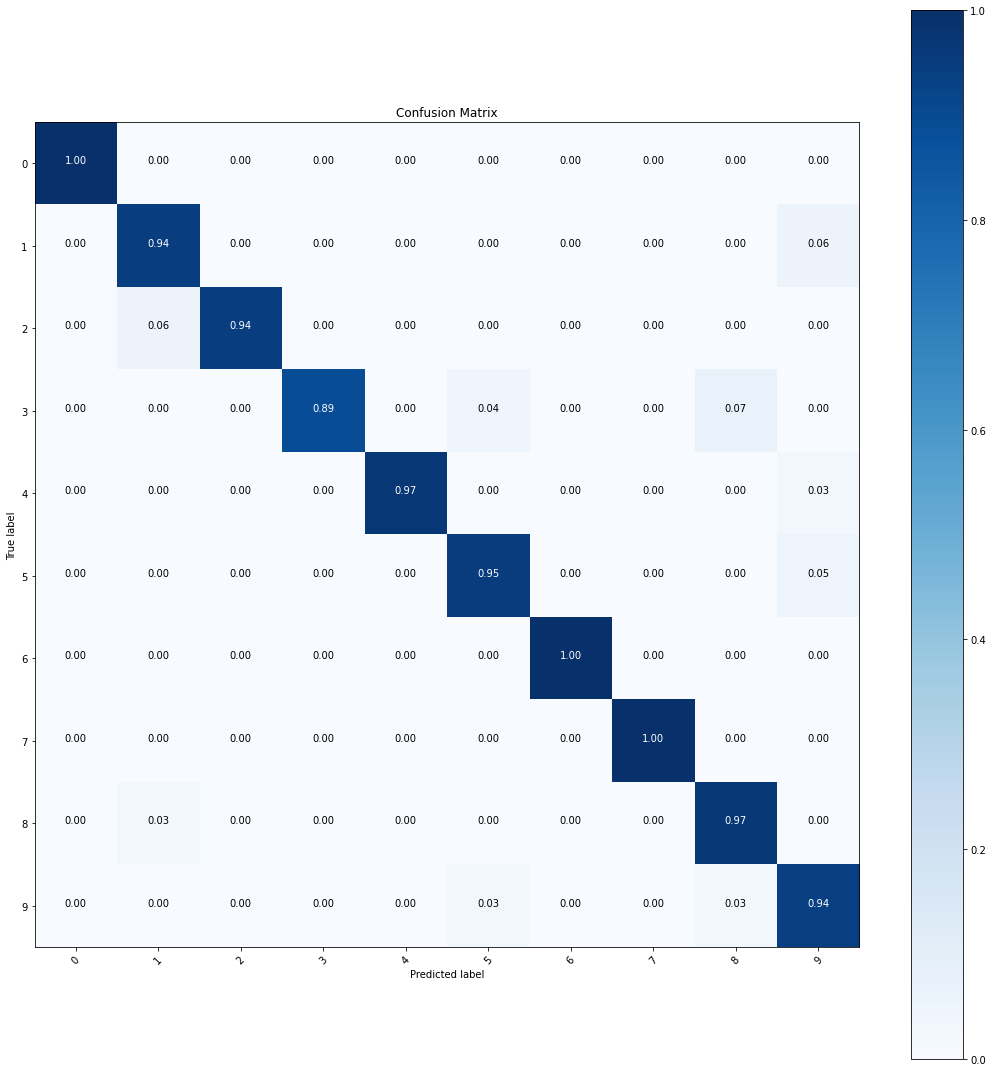

In [62]:
conf_mtx = getConfusionMatrix(y_test, predictions, 10)
plotConfusionMatrix(conf_mtx, 10)

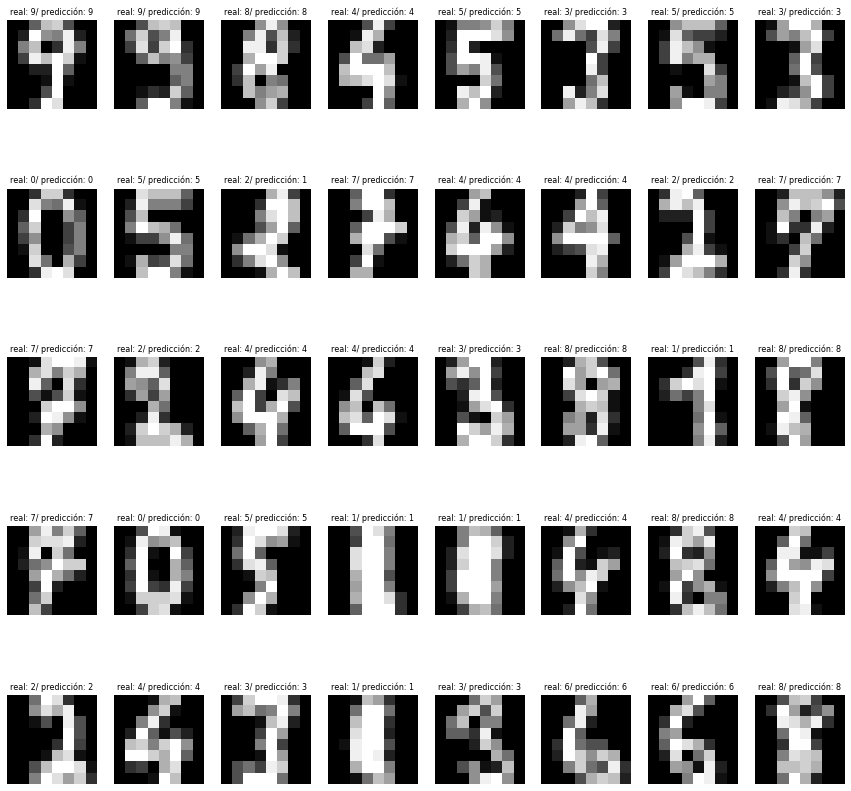

In [63]:
fig = plt.figure(figsize=(15,15))

for i in range(40):  
    ax = fig.add_subplot(5, 8, i+1)
    ax.imshow(X_test[i].reshape(8, 8), cmap=plt.get_cmap('gray'))    
    ax.set_title('real: {y}/ predicción: {y_hat}'.format(y=y_test[i], y_hat=predictions[i]), fontsize=8)
    plt.axis('off')

# IMPLEMENTACIÓN - Regresión logística multiclase empleando librería de sklearn

In [64]:
from sklearn.linear_model import LogisticRegression

# Al definir el parámetro multi_class como 'multinomial' la clase LogisticRegression emplea la función SOFTMAX para realizar la clasificación multiclase
clf = LogisticRegression(random_state=0, max_iter=epochs, C=1/alpha, multi_class='multinomial').fit(X_train_s, y_train.flatten())

In [65]:
# Predicciones con el modelo ajustado
predictions_clf = clf.predict(X_test_s)

In [66]:
# Accuracy
print("La accuracy alcanzada con el modelo provisto es",Acc(y_test, predictions),"mientras que la propia del modelo de sklearn es",Acc(y_test, predictions_clf))

La accuracy alcanzada con el modelo provisto es 0.9583333333333334 mientras que la propia del modelo de sklearn es 0.9638888888888889


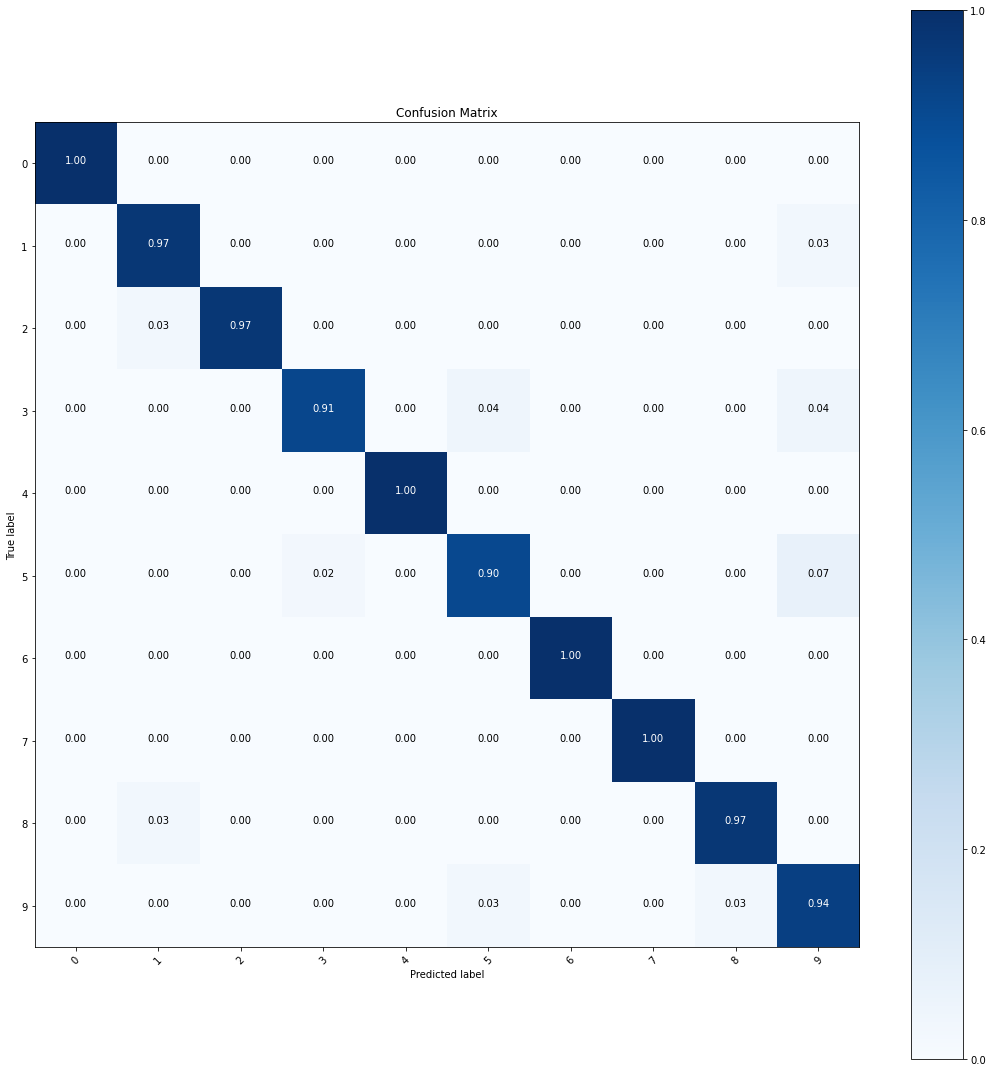

In [67]:
conf_mtx = getConfusionMatrix(y_test, predictions_clf, 10)
plotConfusionMatrix(conf_mtx, 10)

## Alternativa: emplear directamente el clasificador de SGD de sklearn

In [68]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss="log", random_state=0,eta0=lr,max_iter=epochs,alpha=alpha,learning_rate="constant",verbose=True)
model.fit(X_train, y_train)
yhat = model.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 2.37, NNZs: 61, Bias: -0.023302, T: 1437, Avg. loss: 0.151712
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 2.74, NNZs: 61, Bias: -0.029365, T: 2874, Avg. loss: 0.041189
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 2.93, NNZs: 61, Bias: -0.037714, T: 4311, Avg. loss: 0.023208
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 2.99, NNZs: 61, Bias: -0.038149, T: 5748, Avg. loss: 0.014217
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 2.97, NNZs: 61, Bias: -0.034296, T: 7185, Avg. loss: 0.001212
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 3.00, NNZs: 61, Bias: -0.033922, T: 8622, Avg. loss: 0.002826
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 3.16, NNZs: 61, Bias: -0.039258, T: 10059, Avg. loss: 0.006999
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 3.11, NNZs: 61, Bias: -0.039307, T: 11496, Avg. loss: 0.000064
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 3.07, NNZs: 61, Bias: -0.039184, T: 12933, Avg. loss: 0.000055
Total 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


In [69]:
# Accuracy
print("La accuracy alcanzada con el modelo provisto es",Acc(y_test, predictions),"mientras que la propia del modelo de sklearn es",Acc(y_test, yhat))

La accuracy alcanzada con el modelo provisto es 0.9583333333333334 mientras que la propia del modelo de sklearn es 0.9027777777777778
